In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm 
from PIL import Image
from sklearn.model_selection import train_test_split

# timm: PyTorch Image Models
import timm

import shap

# LIME
from lime import lime_image

# For Grad-CAM
import cv2
import torch.nn.functional as F

In [25]:
# Load the trained model instead of retraining
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
model            = timm.create_model('efficientnet_b0', pretrained=False)
num_features     = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)

model.load_state_dict(torch.load('efficientnet_b0_real_vs_fake.pth', map_location=DEVICE))
model = model.to(DEVICE)


print("Model loaded and ready for inference!")

Using device: cuda
Model loaded and ready for inference!


In [26]:
DATA_SET_FOLDER = 'fmd'

In [27]:
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4

In [28]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])



In [29]:
train_dataset_full = datasets.ImageFolder(root=DATA_SET_FOLDER, transform=train_transforms)
val_dataset_full   = datasets.ImageFolder(root=DATA_SET_FOLDER, transform=val_transforms)

In [30]:
indices = list(range(len(train_dataset_full)))
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.15, 
    stratify=train_dataset_full.targets, 
    random_state=42
)

In [31]:
train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [34]:
def train_one_epoch(model, train_loader, optimizer, criterion, device=DEVICE):
    model.train()
    running_loss = 0.0
    correct      = 0
    total        = 0
    
    # Wrap your loader with tqdm for a progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct      += (predicted == labels).sum().item()
        total        += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

def validate_one_epoch(model, val_loader, criterion, device=DEVICE):
    model.eval()
    running_loss = 0.0
    correct      = 0
    total        = 0
    
    # Wrap your loader with tqdm for a progress bar
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss    = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct      += (predicted == labels).sum().item()
            total        += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc



In [35]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc     = validate_one_epoch(model, val_loader, criterion, DEVICE)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")


Epoch [1/5]
Train Loss: 10.5760, Train Acc: 0.4913
Val Loss:   4.1044, Val Acc:   0.6613


Epoch [2/5]
Train Loss: 5.9694, Train Acc: 0.5636
Val Loss:   4.0736, Val Acc:   0.6290


Epoch [3/5]
Train Loss: 3.9348, Train Acc: 0.6561
Val Loss:   3.9275, Val Acc:   0.6129


Epoch [4/5]
Train Loss: 2.5267, Train Acc: 0.6329
Val Loss:   2.6530, Val Acc:   0.6290


Epoch [5/5]
Train Loss: 1.3631, Train Acc: 0.6763
Val Loss:   1.6489, Val Acc:   0.6935


In [36]:
torch.save(model.state_dict(), 'efficientnet_b0_fmd.pth')
print("Model saved to efficientnet_b0_fmd.pth")

Model saved to efficientnet_b0_fmd.pth


In [37]:
def grad_cam(model, image_tensor, target_layer, class_idx=None, device='cuda'):
    """
    model        : trained model
    image_tensor : single image tensor of shape (1, C, H, W)
    target_layer : the specific layer to compute Grad-CAM for (e.g., model.blocks[5][-1].conv_pw)
    class_idx    : which class to visualize Grad-CAM for. If None, uses predicted class.
    device       : device to run the model on (default: 'cuda')
    """
    model.eval()

    # Hook to capture features and gradients
    conv_output = []
    grad_output = []

    def forward_hook(module, inp, out):
        conv_output.append(out)

    def backward_hook(module, grad_in, grad_out):
        grad_output.append(grad_out[0])

    # Register hooks to the specified target layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image_tensor.to(device))
    if class_idx is None:
        class_idx = torch.argmax(output, dim=1).item()

    # Zero grads
    model.zero_grad()
    # Backward pass on the chosen class
    loss = output[0, class_idx]
    loss.backward()

    # Get features and gradients
    activations = conv_output[0].detach().cpu().numpy()[0, :]
    gradients = grad_output[0].detach().cpu().numpy()[0, :]

    # Global average pool the gradients
    weights = np.mean(gradients, axis=(1, 2))

    # Compute weighted combination of activations
    cam = np.zeros(activations.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations[i, :, :]

    # ReLU
    cam = np.maximum(cam, 0)
    # Normalize
    cam -= np.min(cam)
    cam /= np.max(cam) if np.max(cam) != 0 else 1

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    return cam, class_idx

def show_grad_cam_on_image(img_pil, cam):
    """
    Overlays the Grad-CAM heatmap on the original image
    """
    img     = np.array(img_pil)
    h, w, _ = img.shape
    cam = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay_img = heatmap + np.float32(img) / 255
    overlay_img = overlay_img / np.max(overlay_img)
    return np.uint8(255 * overlay_img)


In [38]:
# # Example usage on a single validation image
# example_img_path, ground_truth = val_dataset[200]
# example_img_pil     = Image.open(example_img_path).convert('RGB')
# transform           = val_transforms
# example_img_tensor  = transform(example_img_pil).unsqueeze(0)  # shape: (1, C, H, W)
# 
# _, predicted_class = grad_cam(model, example_img_tensor, None)
# cam, _ = grad_cam(model, example_img_tensor, 1)
# grad_cam_result      = show_grad_cam_on_image(example_img_pil, cam)
# 
# print("Truth: ", ground_truth)
# print("Prediction: ",predicted_class)
# 
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.title("Original")
# plt.imshow(example_img_pil)
# 
# plt.subplot(1,2,2)
# plt.title(f"Grad-CAM (Pred Class: {predicted_class})")
# plt.imshow(grad_cam_result)
# plt.show()

Truth:  0
Prediction:  1


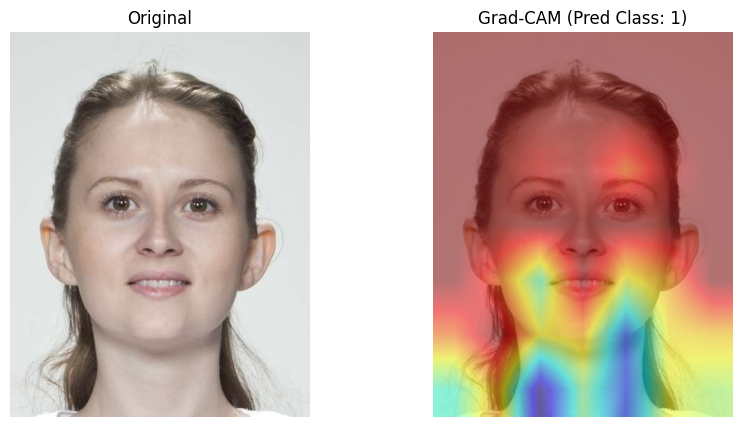

In [85]:
from PIL import Image

# Get the original dataset index
subset_index = 3
original_index = val_indices[subset_index]

# Get image path and label from full dataset
image_path, ground_truth = train_dataset_full.samples[original_index]  # .samples returns (path, class)
example_img_pil = Image.open(image_path).convert('RGB')

# Transform and prepare for inference
example_img_tensor = val_transforms(example_img_pil).unsqueeze(0).to(DEVICE)  # (1, C, H, W)

target_layer = model.blocks[5][1].conv_pwl

# Grad-CAM
_, predicted_class = grad_cam(model, example_img_tensor, target_layer=target_layer ,class_idx=None)
cam, _ = grad_cam(model, example_img_tensor, target_layer=target_layer ,class_idx=None)
grad_cam_result = show_grad_cam_on_image(example_img_pil, cam)

# Display
print("Truth: ", ground_truth)
print("Prediction: ", predicted_class)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(example_img_pil)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM (Pred Class: {predicted_class})")
plt.imshow(grad_cam_result)
plt.axis('off')
plt.show()

Truth:  0
Prediction:  0


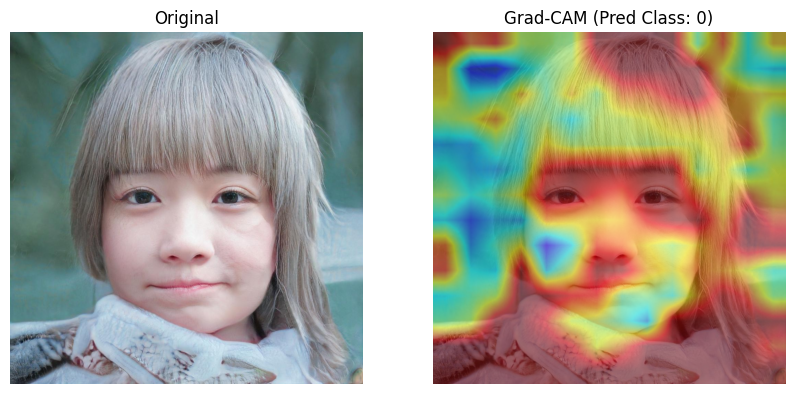

In [235]:

from PIL import Image

# Get the original dataset index
# subset_index = 2022
subset_index = 2029
original_index = val_indices[subset_index]

# Get image path and label from full dataset
image_path, ground_truth = train_dataset_full.samples[original_index]  # .samples returns (path, class)
example_img_pil = Image.open(image_path).convert('RGB')

# Transform and prepare for inference
example_img_tensor = val_transforms(example_img_pil).unsqueeze(0).to(DEVICE)  # (1, C, H, W)

target_layer = model.blocks[3][0].conv_pwl

# Grad-CAM
_, predicted_class = grad_cam(model, example_img_tensor, target_layer=target_layer ,class_idx=None)
cam, _ = grad_cam(model, example_img_tensor, target_layer=target_layer ,class_idx=None)
grad_cam_result = show_grad_cam_on_image(example_img_pil, cam)

# Display
print("Truth: ", ground_truth)
print("Prediction: ", predicted_class)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(example_img_pil)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM (Pred Class: {predicted_class})")
plt.imshow(grad_cam_result)
plt.axis('off')
plt.show()

In [232]:
model.blocks[3][0]

InvertedResidual(
  (conv_pw): Conv2d(40, 240, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (conv_dw): Conv2d(240, 240, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=240, bias=False)
  (bn2): BatchNormAct2d(
    240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (aa): Identity()
  (se): SqueezeExcite(
    (conv_reduce): Conv2d(240, 10, kernel_size=(1, 1), stride=(1, 1))
    (act1): SiLU(inplace=True)
    (conv_expand): Conv2d(10, 240, kernel_size=(1, 1), stride=(1, 1))
    (gate): Sigmoid()
  )
  (conv_pwl): Conv2d(240, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNormAct2d(
    80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Identity()
  )
  (drop_path): Identity()
)

In [149]:
model.blocks

Sequential(
  (0): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (aa): Identity()
      (se): SqueezeExcite(
        (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (act1): SiLU(inplace=True)
        (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (gate): Sigmoid()
      )
      (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Identity()
      )
      (drop_path): Identity()
    )
  )
  (1): Sequential(
    (0): InvertedResidual(
      (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1

  0%|          | 0/2000 [00:00<?, ?it/s]

Truth:  0
Prediction:  0


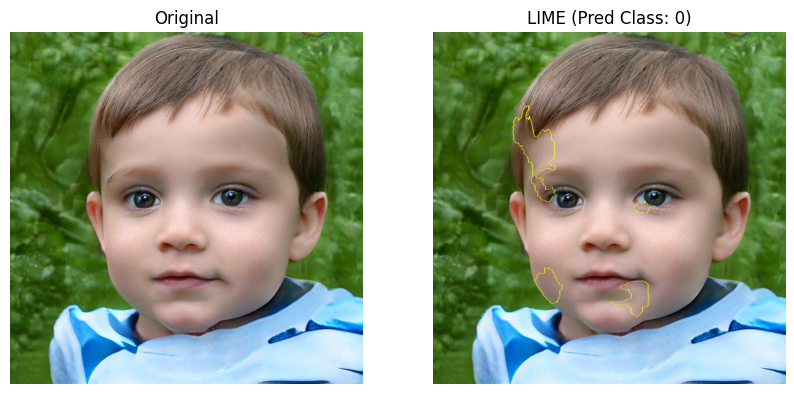

In [223]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
from PIL import Image

# Get the same image as used in Grad-CAM
subset_index = 2002
original_index = val_indices[subset_index]
image_path, ground_truth = train_dataset_full.samples[original_index]
example_img_pil = Image.open(image_path).convert('RGB')

# Transform and prepare for inference (same as Grad-CAM)
example_img_tensor = val_transforms(example_img_pil).unsqueeze(0).to(DEVICE)

# Prepare image for LIME (convert PIL to NumPy array in RGB format)
img_np = np.array(example_img_pil)

# Define a prediction function for LIME
def predict_fn(images):
    # Convert NumPy images to torch tensors
    images = [val_transforms(Image.fromarray(img)).unsqueeze(0) for img in images]
    images = torch.cat(images).to(DEVICE)
    model.eval()
    with torch.no_grad():
        outputs = model(images)
    return outputs.softmax(dim=1).cpu().numpy()

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Compute LIME explanation
explanation = explainer.explain_instance(
    img_np,
    predict_fn,
    top_labels=1,
    num_samples=2000,  # Number of perturbations
    random_seed=42
)

# Get the predicted class
pred = model(example_img_tensor).argmax(dim=1).item()

# Visualize LIME explanation for the predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,  # Number of superpixels to highlight
    hide_rest=False
)

# Display results
print("Truth: ", ground_truth)
print("Prediction: ", pred)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(example_img_pil)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"LIME (Pred Class: {pred})")
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()